Import all  requiered packages

In [1]:
import math as mth
import numpy as np
import os, errno
import pandas as pd
import re
import copy
import matplotlib.pyplot as plt
import matplotlib.patches as pltp
from shapely.geometry import LineString,  Polygon
from shapely.geometry import Point
from shapely.ops import polygonize
import circlify as circ


### Description 
This script is creating a CIF file, which contain a Mask of the Enlarged surafces.
The CIF file itself provides line by line instructions to the software about design of the mask.
The resolution of the design is 0.01 um. 
Description of the CIF commands can be found here:http://www.wieweb.com/download/CleWin4_User_Guide.pdf In section 6.1.





### Principle
1. deternine, which surfaces should be enlarged
2. the size of the enlarged surafeces
3. How surfaces should be loccated on the mask

#### Description of the Algorithm
1. Algorithm loads the design of the Feature from the original TopoChip design
2. the design that consists from single (unique) Feature, is covering the whole circle line by line through several intermediate steps, for eficiency 


1.0 Specify path to the folder with project

In [2]:
path_to_screen="D:/2020_ScreenSOP_JandeBoerLab/"

2.0 Specify Mask Design Properties in 0.01 um
Usual mask has 10 cm which corresponds to BigRadius=5000000, and working area is limited by 1cm from the age  which will match to maskWorkingRadius=4000000
 

In [3]:
BigRadius=5000000
maskWorkingRadius=4000000

3 Define helper Functions

Function to convert Symbol Definitions from the original TopoChip design file to FeatureIdx

In [4]:
def getFeatureDesign2(FeatureIdx):
    
    SymbolStart=(FeatureLibrary.find("FeatureNumber %d"%(FeatureIdx)))
    
    SymbolDStart=(FeatureLibrary.find("NumberOfPrimitives",SymbolStart))
    
    SymbolDStart2=(FeatureLibrary.find("\n",SymbolDStart))
    
    SymbolEnd=(FeatureLibrary.find("SymbolNumber",SymbolDStart2))
    
    return (FeatureLibrary[SymbolDStart2+1:SymbolEnd-1])




in the CIF file every topography design specified as polygons with absolute xy coordinates on the entire mask,function below calculates absolute XY coordinates from the original TopoChip design features definitions 

In [5]:
def DesignToPolygonCoordinatesCircles(FeatureDesign, XCcenter, YCcenter):
    
    #settings for cirelc as in original TopoChip design
    CircleApproximationPoints=12
        
    
    PolygonDesign=""
    
    for primitive in re.split('\n',FeatureDesign) :
       
        if (primitive[0]=="C"):
            
            prim_design=primitive.split()
            
            prim_design[1:] = [ float(x) for x in prim_design[1:] ]
            
            centerXPos=prim_design[1]
            centerYPos=prim_design[2]
            CircleRadius=prim_design[3]
            
            CircleBaseXPosition = XCcenter
            CircleBaseYPosition = YCcenter 
            CircleXPos = float(CircleBaseXPosition + centerXPos)
            CircleYPos = float(CircleBaseYPosition + centerYPos)
            CircleDiameter=CircleRadius*2
            
            PolygonDesign=PolygonDesign+"P "
            
            NumberOfPoints = int(round(CircleApproximationPoints * CircleDiameter * 1.0/100))
            #printf("Number of points = %d\n", NumberOfPoints);
            print("Calculating Distances")
            m=0
            while(m < NumberOfPoints):
                print('.', end='', flush=True)
                XCurr = round(CircleXPos + (CircleRadius * mth.cos (m * 2 * mth.pi/ NumberOfPoints)))
                YCurr = round(CircleYPos + (CircleRadius * mth.sin (m * 2 * mth.pi/ NumberOfPoints)))
                PolygonDesign=PolygonDesign+(" %d %d" % (XCurr, YCurr))
                m+=1
            PolygonDesign=PolygonDesign+";\n "
                
        elif (primitive[0]=="T"):
        
            prim_design=primitive.split()
            
            prim_design[1:] = [ int(x) for x in prim_design[1:] ]
            
            
            TriangleBaseXPosition = XCcenter
            TriangleBaseYPosition = YCcenter
                        
            AXPos=prim_design[1]+TriangleBaseXPosition
            AYPos=prim_design[2]+TriangleBaseYPosition
            BXPos=prim_design[3]+TriangleBaseXPosition
            BYPos=prim_design[4]+TriangleBaseYPosition
            CXPos=prim_design[5]+TriangleBaseXPosition
            CYPos=prim_design[6]+TriangleBaseYPosition
            
            PolygonDesign=PolygonDesign+"P %d %d %d %d %d %d;\n "% ( AXPos, AYPos, BXPos, BYPos, CXPos, CYPos)
            
        elif (primitive[0]=="L"):
            
            prim_design=primitive.split()
            
            prim_design[1:] = [ int(x) for x in prim_design[1:] ]
            
            
            LineBaseXPosition = XCcenter
            LineBaseYPosition = YCcenter
        
            TLXPos=prim_design[1]+LineBaseXPosition
            TLYPos=prim_design[2]+LineBaseYPosition
            BLXPos=prim_design[3]+LineBaseXPosition
            BLYPos=prim_design[4]+LineBaseYPosition
            BRXPos=prim_design[5]+LineBaseXPosition
            BRYPos=prim_design[6]+LineBaseYPosition
            TRXPos=prim_design[7]+LineBaseXPosition
            TRYPos=prim_design[8]+LineBaseYPosition
            
            PolygonDesign=PolygonDesign+"P %d %d %d %d %d %d %d %d;\n " % (TLXPos, TLYPos, BLXPos, BLYPos, BRXPos, BRYPos, TRXPos, TRYPos)
            
            
                
    return(PolygonDesign)
       
 

Load TopoChip Design File

In [6]:
librrayfile2= open (path_to_screen+"4_analysis//dataAnalysis//meta//data//PrimitivesComposingFeatures.txt", "rt") 
FeatureLibrary = librrayfile2.read()
librrayfile2.close()

Load Feature Idx ptroperties file, needed to know the size of the Topofeature, which is 10, 20 or 28

In [7]:
##Make a conversion file from the existing design to the FeatureIdx
conv_mask=pd.DataFrame({ 'FeatureIdx' : list(range(1,2178)),
    'SymbolIdx' : list(range(7,6536,3)) })
#load topographical librray
featur_prop=pd.read_csv(path_to_screen+"4_analysis//dataAnalysis//meta//data//indexes_features.csv", sep=";",low_memory=False)


4 Determine the size and number of surfaces

Go to website and find out what is most optimal number of surfaces given their size https://www.engineeringtoolbox.com/smaller-circles-in-larger-circle-d_1849.html

Alternatively use infinite hexagonal packing aproximation, as defined for circles below, but this is aproximation and keep in mind that number of circels will be less

In [8]:
def approximateNumberOfSurfaces(maskWorkingRadius, singleSurfaceRadius):
    # Use  infinite hexagonal packing aproximation
    #AreaOfMask=(np.pi*maskWorkingRadius) ** 2
    #surfaceArea=(np.pi*singleSurfaceRadius) ** 2
    
    return np.int(( np.pi * (maskWorkingRadius**2))/ ((singleSurfaceRadius**2)*np.sqrt(12)))
    


Specify aproximately the radius and gap between surfaces in 0.01 um

In [9]:
gapBetweenSurfaces=20000
ApprSingleSurfaceRadius=600000

In [10]:
numberOfSurfaces=approximateNumberOfSurfaces(maskWorkingRadius=(maskWorkingRadius-gapBetweenSurfaces), 
                                             singleSurfaceRadius=(ApprSingleSurfaceRadius+gapBetweenSurfaces))
print(numberOfSurfaces)

37


Define the function to vizualzie the packing of the specified number 
of circles, the function uses circlify package: https://github.com/elmotec/circlify

In [11]:
def showSurfacePacking(numberOfSurfaces):
    numberIncludingBigCircle=numberOfSurfaces
    circles = circ.circlify([1]*numberIncludingBigCircle,show_enclosure=True)
    
    
    circledataAll=[]
    for circle in circles:
        #print (circledataAll)
        circledata = list(circle.circle)        
        circledataAll.append(circledata)
        
    circledataDFAll=pd.DataFrame(data=circledataAll,columns=["x","y","r"])
    circledataDFAll["Label"]=np.linspace(0,numberOfSurfaces,numberIncludingBigCircle+1,dtype=int)
    
     
    circledataDFAll.loc[circledataDFAll.Label==0,"Label"]=-1
    
    circledataDFAll.x=circledataDFAll.x*maskWorkingRadius
    circledataDFAll.y=circledataDFAll.y*maskWorkingRadius
    circledataDFAll.r=circledataDFAll.r*maskWorkingRadius
    
    radiusOfSingleSurface=np.min(circledataDFAll.r)
    
    print("Aproximated radius of the sigle large surface based on %s surafces is %f um"%(
        numberOfSurfaces,radiusOfSingleSurface-gapBetweenSurfaces))
    
    
    circ.bubbles(circles,circledataDFAll.Label)
    return circledataDFAll

Show packing and calculate XY  coordiantes of every circle and radius, 
where the first coordinates corresponds to the working area mask, and it has label -1

Aproximated radius of the sigle large surface based on 37 surafces is 551428.571429 um


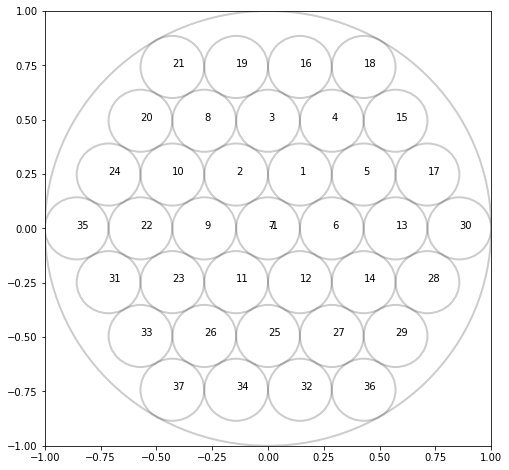

,x,y,r,Label
0,0.000000e+00,0.000000e+00,4.000000e+06,-1
1,5.714286e+05,9.897433e+05,5.714286e+05,1
2,-5.714286e+05,9.897433e+05,5.714286e+05,2
3,0.000000e+00,1.979487e+06,5.714286e+05,3
4,1.142857e+06,1.979487e+06,5.714286e+05,4
5,1.714286e+06,9.897433e+05,5.714286e+05,5
6,1.142857e+06,1.015061e-09,5.714286e+05,6
7,0.000000e+00,1.015061e-09,5.714286e+05,7
8,-1.142857e+06,1.979487e+06,5.714286e+05,8
9,-1.142857e+06,1.776357e-09,5.714286e+05,9


In [12]:
numberOfSurfaces=37

xycoordinatesLargeSurfaces=showSurfacePacking(numberOfSurfaces)
xycoordinatesLargeSurfaces


Alternatevely, specify coordinates manually

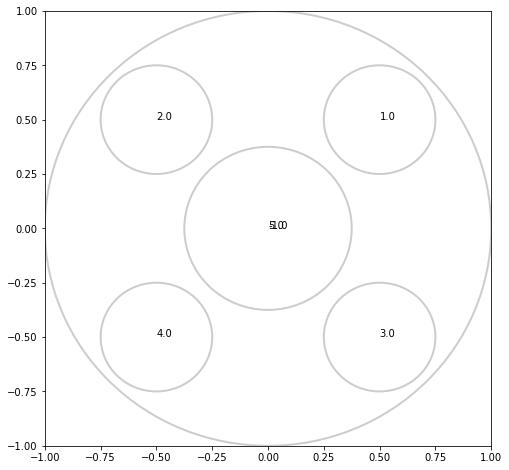

,x,y,r,Label
0,0,0,4000000,-1
1,2000000,2000000,1000000,1
2,-2000000,2000000,1000000,2
3,2000000,-2000000,1000000,3
4,-2000000,-2000000,1000000,4
5,0,0,1500000,5


In [13]:
manualCircleCoordinates=[
                            [0,0,4000000,-1],                        
                            [2000000,2000000,1000000,1],
                            [-2000000,2000000,1000000,2],
                            [2000000,-2000000,1000000,3],
                            [-2000000,-2000000,1000000,4],
                            [0,0,1500000,5],
                                ]# x,y,r,Label


xycoordinatesLargeSurfacesManual=pd.DataFrame(data=manualCircleCoordinates,columns=["x","y", "r","Label"])

fig, ax = plt.subplots(figsize=(8.0, 8.0))

circledataManualPlot=xycoordinatesLargeSurfacesManual.copy()
circledataManualPlot.loc[:, ["x","y", "r"]]=circledataManualPlot.loc[:, ["x","y", "r"]].divide(
    circledataManualPlot["r"].max(), axis=1)

for index, row in circledataManualPlot.iterrows():
    ax.add_patch(pltp.Circle((row.x, row.y), row.r, alpha=0.2,
                             linewidth=2, fill=False))
    ax.text(row.x, row.y, row.Label)

lim = circledataManualPlot["r"].max()
plt.xlim(-lim, lim)
plt.ylim(-lim, lim)
plt.show()

xycoordinatesLargeSurfacesManual


Specify FeatureIdxs, that need to be fabricated.

In [14]:
##List of surfaces for the mask


listFeatureIdx=list([1008, 281, 2135, 1689, 1])


In [15]:
for CrazyyStaff, CircleFeatureIx in enumerate(listFeatureIdx): 
    #print(xycoordinatesLargeSurfaces.loc[fi])
    print("Then next Line")
    

Then next Line
Then next Line
Then next Line
Then next Line
Then next Line


Define a function that make a CIF mask file, 
it removes any mask in the main folder with exact the same name
It requeres to specify coordinates file, either automatic or manual,
And Selected FeatureIdx list


In [16]:
def makeMask(filename, coordinatesData, listFeatureIdx):
    
    #function to remove filename if exists
    def silentremove(filename):
        try:
            os.remove(filename)
        except OSError as e: # this would be "except OSError, e:" before Python 2.6
            if e.errno != errno.ENOENT: # errno.ENOENT = no such file or directory
                raise # re-raise exception if a different error occured

    silentremove(filename)  

    maskFile=path_to_screen+filename
    
    #start writing a mask    
    with open(maskFile, 'w') as feat:
        
        #specify precision
        feat.write("(1 unit = 0.01 micron);\n")
        #specify the layer
        feat.write("L L0;\n")
        
        #remove the first xy coordinates, which belong to working area
        coordinatesData=coordinatesData.loc[1:,:].reset_index(drop=True)
        
        #Create definition Number variable and variable that will keep track of the definitions
        DefinitionNumber=-1
        lastdef=[]
        
        #iterate the algorithm through FeatureIdx
        for fi, CircleFeatureIx in enumerate(listFeatureIdx): 

            print("FeatureIdx %s"%CircleFeatureIx)
            print('Filling Circles', end='', flush=True)
            
            ##Define the edge position of the circl to start writing design
            
            singleSurfaceRadius=coordinatesData.r.loc[fi]
            seed_X=coordinatesData.x.loc[fi]-singleSurfaceRadius
            seed_Y=coordinatesData.y.loc[fi]
            
            
            #Write information in the file
            DefinitionNumber+=1
            feat.write("DS %d 1 1;\n" % DefinitionNumber)
            feat.write(DesignToPolygonCoordinatesCircles(getFeatureDesign2(CircleFeatureIx), seed_X, seed_Y))
            feat.write("DF;\n")

            ##Define a block of features with size 280 x 280 um
            FeatureBlock=28000
            #load information about FeatureSize
            FeatureSize=100*featur_prop.FeatSize.loc[featur_prop["feature idx"]==CircleFeatureIx]
            #Determine how many FeatureIdxs are requered to cover specified area
            FeatureRepetition1 = mth.ceil(FeatureBlock/FeatureSize) 
            
            # start writing a FeatureBlock
            DefinitionNumber+=1
            feat.write("DS %d 1 1;\n" % DefinitionNumber)
            rows=0

            while(rows<FeatureRepetition1):
                print('*', end='', flush=True)
                TransX1 = rows * FeatureSize
                feat.write("C %d T %d 0;\n" % (DefinitionNumber-1, TransX1))
                rows+=1
            feat.write("DF;\n")

            DefinitionNumber+=1
            feat.write("DS %d 1 1;\n" % DefinitionNumber)
            cols=0
            while(cols<FeatureRepetition1):

                TransY1 = cols * FeatureSize#*np.sign(coordinatesData.y.loc[fi])
                feat.write("C %d T 0 %d;\n" % (DefinitionNumber-1, TransY1))
                cols+=1

            feat.write("DF;\n")
            
            #end of Feature block
            
            #remeber the definition number of the block

            CurrentCircleF=DefinitionNumber

            # Calculate how many lines in X direction, consisted of FeatureBlock are neded to cover the whole circle
            LinesinCircle=mth.ceil((singleSurfaceRadius*2)/FeatureBlock)
            #define some variables that will be used 
            lm=1
            X_orig=seed_X
            Y_orig=seed_Y
            
            #Start filling circle with lines
            while(lm<int(LinesinCircle)):

                print('.', end='', flush=True)

                #calculate in um the distance on which design should be copied
                TransX = lm*FeatureBlock

                ##Copy a Feature Block to calculated distance

                DefinitionNumber+=1
                feat.write("DS %d 1 1;\n" % DefinitionNumber)
                feat.write("C %d T %d 0;\n" % (CurrentCircleF, TransX))
                feat.write("DF;\n")
                
                #Calculate the length of the lines, that is neded to cover from the center of circle to edge
                
                # draw a circle
                p = Point(coordinatesData.x.loc[fi], coordinatesData.y.loc[fi])
                c = p.buffer(singleSurfaceRadius).boundary
                #draw a line throw the circle
                ly = LineString([(X_orig+TransX,-BigRadius*1.2), (X_orig+TransX, BigRadius*1.2)])# 1.2 is an arbitrary offset factor
                # make a line that is limited by circl
                iy = c.intersection(ly)
                
                #Find the half length of the found line      
                CrossSectionLength=LineString(iy).length/2
                #Calculate how many FeatureBlocks are requered to cover hte full line in Y direction 
                FeatureRepetition = mth.ceil(CrossSectionLength/FeatureBlock) 
                
                #Start writing
                DefinitionNumber+=1
                feat.write("DS %d 1 1;\n" % DefinitionNumber)
                
                m=0
                while(m<FeatureRepetition):
                    #Find distance in um on which the design should be copied
                    TransY=FeatureBlock*m
                    #Copy the Surafce design above and below the line
                    feat.write("C %d T 0 %d;\n" % (DefinitionNumber-1, 1*TransY))
                    feat.write("C %d T 0 %d;\n" % (DefinitionNumber-1, -1*TransY))
                    m+=1
                    print('.', end='', flush=True)
                feat.write("DF;\n")
                #The circle is filled with FeatureIdx now
                #Remember all the DFs
                temps="".join(["C ",str(DefinitionNumber),";\n"]) # the first call statement
                lastdef.append(temps)

                lm+=1

            fi+=1
        #Finalize the massk file
        DefinitionNumber+=1
        feat.write("DS %d 1 1;\n" % DefinitionNumber)
        mm=0
        while(mm<len(lastdef)):
            feat.write( "%s"  % str(lastdef[mm]))
            mm+=1
        feat.write("DF;\n")
        AllcirclesDefinition=DefinitionNumber
        DefinitionNumber+=1
        feat.write("DS %d 1 1;\n" % DefinitionNumber)
        feat.write("C %d;\n" % AllcirclesDefinition)
        feat.write("DF;\n")
        feat.write("C %d;\n" % DefinitionNumber)
        feat.write("E\n")
        #The end

Execute MakeMask function

In [17]:
makeMask(filename="MaskTest.cif",
        coordinatesData=xycoordinatesLargeSurfacesManual,
        listFeatureIdx=listFeatureIdx)

FeatureIdx 1008
Filling CirclesCalculating Distances
........................................Calculating Distances
........................................Calculating Distances
........................................Calculating Distances
........................................Calculating Distances
........................................Calculating Distances
........................................Calculating Distances
........................................Calculating Distances
........................................**************...........................................................................................................................................................................................................................................................................................................................................................................................................................................................................

......................................................................................................**************....................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................